### Cargar y mapear usuarios:

In [50]:
import warnings
warnings.filterwarnings("ignore")

In [51]:
import pandas as pd
columnas = ["user_id","mbti"]
data = pd.read_json("../data/data_spanish/TwiSty-ES.json",orient="index")
data = data[columnas].reset_index(drop=True)
data

,user_id,mbti
0,54056853,ENTJ
1,2573243225,INFP
2,399751937,INTP
3,541982091,INFJ
4,70392126,ISTJ
...,...,...
10767,165848831,ENFP
10768,128377140,INFJ
10769,122450877,ESFJ
10770,248404858,ENTJ


In [52]:
with open("../data/data_spanish/tweets.json", "r") as f1:
    corpus = json.load(f1)
    f1.close()

In [53]:
# Juntar ID de usuarios y tipo con tweets guardados en corpus
data["corpus"] = data["user_id"].apply(lambda x: corpus[str(x)])

data["n_texts"] = data["corpus"].apply(lambda x: len(x))

data = data[data["n_texts"]!=0]

del corpus 

In [54]:
def count_words(x):
    n = 0
    for lista in x: 
        words_i = len(lista.split())
        n += words_i
    return n


data["n_words"] = data["corpus"].apply(lambda x: count_words(x))

In [55]:
print(data.shape)
data.head()

(8900, 5)


,user_id,mbti,corpus,n_texts,n_words
0,54056853,ENTJ,[@IvoCaracas Que mirada tan interesante la de ...,2120,16748
1,2573243225,INFP,"[:(, ¿Algún día... podré ser bonita? :(, 😍😍😍😍😍...",1571,11279
3,541982091,INFJ,"[8 o 9... y porque Iroh está con el que está, ...",1022,25013
4,70392126,ISTJ,[Cinco años sin participar de un día como este...,1636,25549
5,30972914,ENTP,[Acabo de terminar de ver Gilmore Girls por mi...,2125,23108


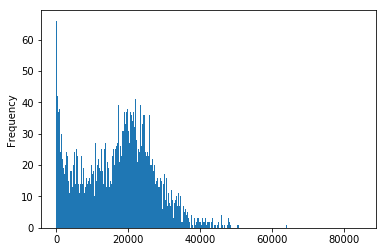

In [79]:
#Distribución de total de palabras por usuario:
data["n_words"].plot(kind="hist",bins=1000);

(7313,)

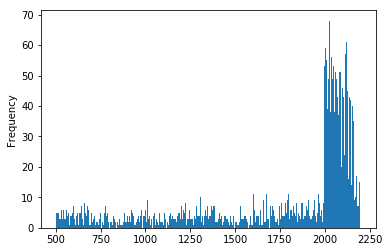

In [21]:
a = data["n_texts"]
b = a[(a>500)]
b.plot(kind="hist", bins = 1000);
b.shape

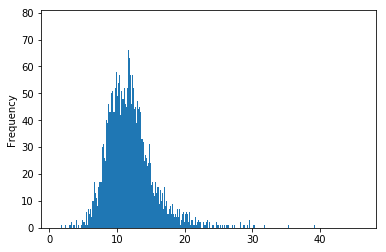

In [69]:
# Distribución de total de palabras medias por comentario: 
a = data["n_words"]/data["n_texts"]
data["mean_words"] = a
a.plot(kind="hist",bins=1000);
del a 

### Filtrar usuarios para obtener datos lo mas homogeneos posibles: 

In [120]:
a = data[(data["mean_words"]>7) & (data["mean_words"]<15)]
b = a[(a["n_words"]>10000)&(a["n_words"]<30000)]
new_data = b.copy()
del a,b

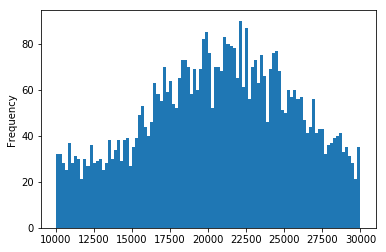

In [121]:
#Distribución de total de palabras por usuario:
new_data["n_words"].plot(kind="hist",bins=100);

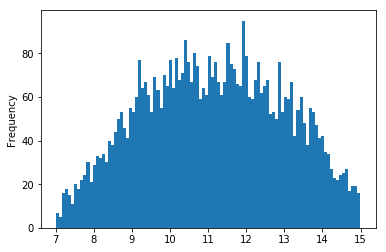

In [122]:
#Distribución de total de palabras por usuario:
new_data["mean_words"].plot(kind="hist",bins=100);

In [123]:
new_data.shape

(5067, 6)

De los 8 mil usuarios me quedaré con 5000 mil, obteniendo con ellos una distribución bastante mejor

In [159]:
data = new_data.reset_index(drop=True)

### Juntar tweets

In [58]:
data.head()

,user_id,mbti,corpus,n_texts,n_words
0,54056853,ENTJ,[@IvoCaracas Que mirada tan interesante la de ...,2120,16748
1,2573243225,INFP,"[:(, ¿Algún día... podré ser bonita? :(, 😍😍😍😍😍...",1571,11279
3,541982091,INFJ,"[8 o 9... y porque Iroh está con el que está, ...",1022,25013
4,70392126,ISTJ,[Cinco años sin participar de un día como este...,1636,25549
5,30972914,ENTP,[Acabo de terminar de ver Gilmore Girls por mi...,2125,23108


In [59]:
data["texts"] = data["corpus"].apply(lambda x: x[:500])  # Quedarse solo los primeros 500 Tweets 

In [60]:
data["texts"] = data["texts"].apply(lambda x: " ".join(x))  #Juntar Tweets 

## Clean texts:

### Eliminar enlaces y hashtags

In [61]:
data.head()

,user_id,mbti,corpus,n_texts,n_words,texts
0,54056853,ENTJ,[@IvoCaracas Que mirada tan interesante la de ...,2120,16748,@IvoCaracas Que mirada tan interesante la de P...
1,2573243225,INFP,"[:(, ¿Algún día... podré ser bonita? :(, 😍😍😍😍😍...",1571,11279,:( ¿Algún día... podré ser bonita? :( 😍😍😍😍😍😍😍😍...
3,541982091,INFJ,"[8 o 9... y porque Iroh está con el que está, ...",1022,25013,"8 o 9... y porque Iroh está con el que está, s..."
4,70392126,ISTJ,[Cinco años sin participar de un día como este...,1636,25549,Cinco años sin participar de un día como este....
5,30972914,ENTP,[Acabo de terminar de ver Gilmore Girls por mi...,2125,23108,Acabo de terminar de ver Gilmore Girls por mil...


In [71]:
mbti = ['intj', 'enfp', 'entp', 'intp', 'esfp', 'infp', 'infj', 'istp', 'istj', 'entj','enfj', 'isfj', 'estj', 'estp', 'isfp', 'esfj']
def remove_mbti(x):
    x = str(x)
    for p in mbti:
        if p in x:
            x = x.replace(p, " ")
    return x

data["clean_text"] = data["texts"].apply(lambda x: remove_mbti(x.lower()))

In [87]:
import re 

def clean_text(x):

    x = x.lower()

    x = re.compile('htt\S+').sub(' enlace ',x)
    x = re.compile('@\S+').sub(' mencion ',x)
    x = re.compile('#\S+').sub(' hashtag ',x)
    
    x = re.sub(r"[^a-zA-Z.áéíóúñ]", ' ', x)
    x = re.compile('jaja\S+').sub(' jaja ',x) 
    x = re.sub(r" +", ' ', x)
    return x


In [88]:
data["clean_text"] = data["texts"].apply(clean_text)

In [89]:
data.head()

,user_id,mbti,corpus,n_texts,n_words,texts,clean_text
0,54056853,ENTJ,[@IvoCaracas Que mirada tan interesante la de ...,2120,16748,@IvoCaracas Que mirada tan interesante la de P...,mencion que mirada tan interesante la de plut...
1,2573243225,INFP,"[:(, ¿Algún día... podré ser bonita? :(, 😍😍😍😍😍...",1571,11279,:( ¿Algún día... podré ser bonita? :( 😍😍😍😍😍😍😍😍...,algún día... podré ser bonita enlace tiempo d...
3,541982091,INFJ,"[8 o 9... y porque Iroh está con el que está, ...",1022,25013,"8 o 9... y porque Iroh está con el que está, s...",o ... y porque iroh está con el que está sino...
4,70392126,ISTJ,[Cinco años sin participar de un día como este...,1636,25549,Cinco años sin participar de un día como este....,cinco años sin participar de un día como este....
5,30972914,ENTP,[Acabo de terminar de ver Gilmore Girls por mi...,2125,23108,Acabo de terminar de ver Gilmore Girls por mil...,acabo de terminar de ver gilmore girls por mil...


In [90]:
data.to_csv("../data/data_spanish/data_spanish.csv",index=False)